# Лабораторная работа 1. Кластерный анализ

In [3]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import os

In [18]:
data = pd.read_csv('Econom_Cities_data.csv', sep = ';',index_col='City',decimal=',')
data.head()

,Work,Price,Salary
City,,,
Amsterdam,1714,65.6,49.0
Athens,1792,53.8,30.4
Bogota,2152,37.9,11.5
Bombay,2052,30.3,5.3
Brussels,1708,73.8,50.5


Данные по количеству рабочих часов(Work) на несколько порядков больше данных по другим переменным, выполним стандартизацию данных при помощи z-преобразования

In [5]:
from sklearn import preprocessing

stand_1 = preprocessing.StandardScaler()

# параметры стандартизации
stand_1.fit(data)
# преобразование
X = stand_1.transform(data)
X = pd.DataFrame(X, index=data.index, columns=data.columns)

X.head()

,Work,Price,Salary
City,,,
Amsterdam,0.138269,-0.151250,0.213212
Athens,0.171046,-0.698647,0.203941
Bogota,0.322325,-1.436242,0.194519
Bombay,0.280303,-1.788804,0.191429
Brussels,0.135748,0.229145,0.213960


In [6]:
data_sd = X

# 1. Иерархический кластерный анализ

In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

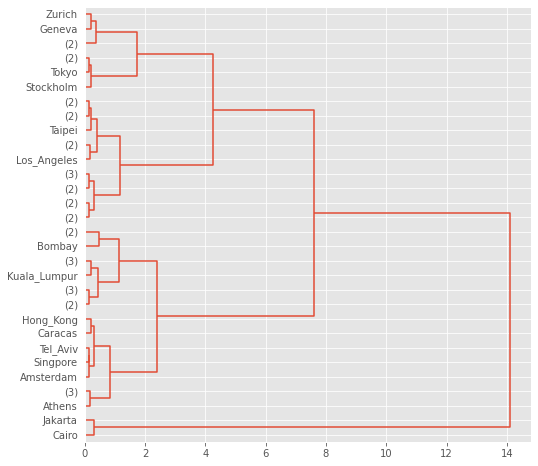

In [8]:
#  построим дендрограмму

link = linkage(data_sd, 'ward', 'euclidean')

fig = plt.figure(figsize = (8,8))
dn = dendrogram(link,
                labels = X.index.tolist(),
                truncate_mode='lastp',
                color_threshold = 0,
                orientation = "right",
                leaf_rotation=0.)

По дендрограмме можно увидеть, что алгоритм объединил города, как расположенные географически близко друг от друга (например Женева и Цюрих), так и города, обладающие сходными функциями (например, рядом расположены портовые Амстердам, Сингапур и Гонконг).

Сложно судить, какие из факторов больше влияют на формирование экономических характеристик города, следовательно, неоднозначно определяется расстояние, на котором следует остановить объединение в кластеры (предположительно около 4 или меньше - около 2). Джакарта и Каир, оказавшиеся в самом малочисленном кластере, вероятно, могут быть выбросами.

Посмотрим на "каменистую осыпь" для этой выборки.

Text(0, 0.5, 'Расстояние')

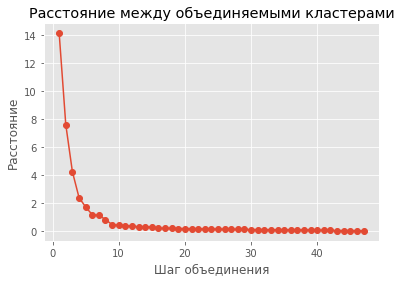

In [9]:
dist = link[:, 2] # извлекаем из матрицы столбец расстояний
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Расстояние между объединяемыми кластерами')
plt.xlabel('Шаг объединения')
plt.ylabel('Расстояние')

Резкий скачок величины расстояния происходит при расстоянии большем 2 и меньшем 4. Судя по дендрограмме, это расстояние равно около 2,7, что соответсвует 4 кластерам.

In [10]:
# Останавливаем объединение, когда расстояние между кластерами превысит 2.7
data['cluster'] = fcluster(link, 2.7, criterion='distance')
data.head()

,Work,Price,Salary,cluster
City,,,,
Amsterdam,1714,65.6,49.0,2
Athens,1792,53.8,30.4,2
Bogota,2152,37.9,11.5,2
Bombay,2052,30.3,5.3,2
Brussels,1708,73.8,50.5,3


Рассмотрим состав кластеров

In [47]:
data[data['cluster']==1].index.values # смотрим на состав кластеров

array(['Cairo', 'Jakarta'], dtype=object)

In [48]:
data[data['cluster']==2].index.values

array(['Amsterdam', 'Athens', 'Bogota', 'Bombay', 'Buenos_Aires',
       'Caracas', 'Hong_Kong', 'Johannesburg', 'Kuala_Lumpur', 'Lagos',
       'Lisbon', 'Manila', 'Mexico_City', 'Nairobi', 'Nicosia', 'Panama',
       'Rio_de_Janeiro', 'San_Paulo', 'Seoul', 'Singpore', 'Tel_Aviv'],
      dtype=object)

In [49]:
data[data['cluster']==3].index.values

array(['Brussels', 'Chicago', 'Dublin', 'Dusseldorf', 'Frankfurt',
       'Houston', 'London', 'Los_Angeles', 'Luxembourg', 'Milan',
       'Montreal', 'New_York', 'Paris', 'Sydney', 'Taipei', 'Toronto',
       'Vienna'], dtype=object)

In [50]:
data[data['cluster']==4].index.values

array(['Copenhagen', 'Geneva', 'Helsinki', 'Madrid', 'Oslo', 'Stockholm',
       'Tokyo', 'Zurich'], dtype=object)

In [51]:
data.groupby('cluster').mean()

,Work,Price,Salary
cluster,,,
1,-9999.000000,40.350000,-9999.000000
2,1967.333333,51.504762,17.038095
3,1826.588235,76.858824,54.152941
4,1763.750000,104.550000,67.587500


Интерпретация

1-ый кластер состоит из городов Каир и Джакарта. Несмотря на то, что эти города действительно имеют сходства, средние показатели Work и Salary отрицательны, хотя это взвешенное среднее числа рабочих часов и ЗП. Возможно -9999 является обозначением для очень низкого значения показателей или отсутсвия данных. Тогда Каир и Джакарта - выбросы и кластеризацию стоит произвести повторно, удалив их из датасета.

In [15]:
data_2 = pd.read_csv('Econom_Cities_data.csv', sep = ';',decimal=',')
data_2[(data['City']=='Cairo')|(data['City']=='Jakarta')]

,City,Work,Price,Salary
6,Cairo,-9999,37.1,-9999.0
17,Jakarta,-9999,43.6,-9999.0


2-ой кластре характеризуется самым большим из всех кластеров числом рабочих часов, низкими уровнями цен и зарплат. В данный кластер входят преимущественно города юго-восточной Азии (в том числе островов - Филлипинская Манила, Сингапур, Куалу-Лумпур) и Южной Америки.

То есть это развивающиеся (в том числе бедные) страны с тёплым климатом и высокой долей сельского хозяйства и ручного труда в экономике.

3-ий кластер характеризуется меньшим количеством рабочих часов и более высокими ценами и зарплатами. Он в большей степени состоит из достаточно развитых городов передовых регионов - Европы и Северной Америки.

4-ый кластер отличается самым высоким уровнем цен и зарплат на фоне самого низкого показателя рабочих часов, что говорит о том, что в него входят наиболее развитые страны с с высоким уровнем автоматизации и наукоёмкости производства. Действительно, кластер формируют города стран северной Европы и Токио, известные как одни из самых дорогих и экономически развитых стран мира.

Теперь удалим города-выбросы Каир и Джакарта и проведём анализ повторно, сравним результаты.

In [33]:
data_out = data.drop('Cairo')
data_out = data_out.drop('Jakarta')
data_out.head()

,Work,Price,Salary
City,,,
Amsterdam,1714,65.6,49.0
Athens,1792,53.8,30.4
Bogota,2152,37.9,11.5
Bombay,2052,30.3,5.3
Brussels,1708,73.8,50.5


In [34]:
stand_2 = preprocessing.StandardScaler()

# параметры стандартизации
stand_2.fit(data_out)
# преобразование
X = stand_2.transform(data_out)
X = pd.DataFrame(X, index=data_out.index, columns=data_out.columns)

X.head()

,Work,Price,Salary
City,,,
Amsterdam,-0.962166,-0.212712,0.386095
Athens,-0.509827,-0.770489,-0.373488
Bogota,1.577891,-1.522069,-1.145323
Bombay,0.997969,-1.881316,-1.398517
Brussels,-0.996961,0.174896,0.447351


In [37]:
data_sd_2 = X

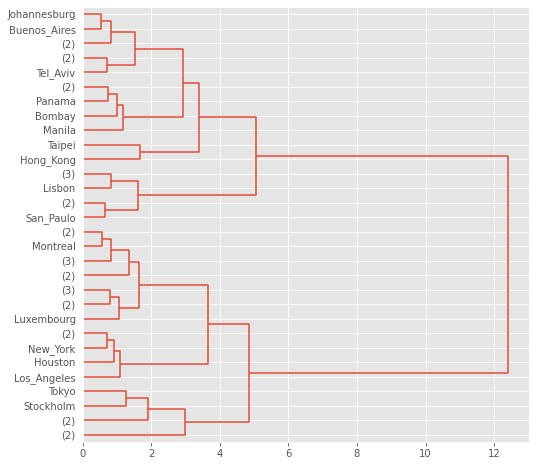

In [39]:
#  построим дендрограмму

link = linkage(data_sd_2, 'ward', 'euclidean')

fig = plt.figure(figsize = (8,8))
dn = dendrogram(link,
                labels = X.index.tolist(),
                truncate_mode='lastp',
                color_threshold = 0,
                orientation = "right",
                leaf_rotation=0.)

Предположительно оъединение в кластеры стоит прервать при расстоянии ~4, так как при уменьшении этого расстояния число кластеров очень быстро будет расти и кластеры будут малочисленными.

Text(0, 0.5, 'Расстояние')

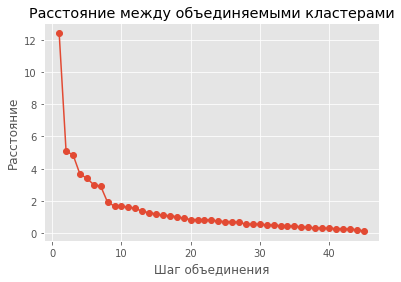

In [40]:
dist = link[:, 2] # извлекаем из матрицы столбец расстояний
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Расстояние между объединяемыми кластерами')
plt.xlabel('Шаг объединения')
plt.ylabel('Расстояние')

Расстояние 4 так же просматривается на графике каменистой осыпи - при снижении расстояния меньше 4 есть "ступенька" близко расположенных друг к другу точек

In [51]:
# Останавливаем объединение, когда расстояние между кластерами превысит 2.7
data_out['cluster'] = fcluster(link, 4, criterion='distance')
data_out.head()

,Work,Price,Salary,cluster
City,,,,
Amsterdam,1714,65.6,49.0,2
Athens,1792,53.8,30.4,3
Bogota,2152,37.9,11.5,4
Bombay,2052,30.3,5.3,4
Brussels,1708,73.8,50.5,2


In [42]:
data_out[data_out['cluster']==1].index.values # смотрим на состав кластеров

array(['Geneva', 'Helsinki', 'Oslo', 'Stockholm', 'Tokyo', 'Zurich'],
      dtype=object)

In [43]:
data_out[data_out['cluster']==2].index.values

array(['Amsterdam', 'Brussels', 'Chicago', 'Copenhagen', 'Dublin',
       'Dusseldorf', 'Frankfurt', 'Houston', 'London', 'Los_Angeles',
       'Luxembourg', 'Madrid', 'Milan', 'Montreal', 'New_York', 'Paris',
       'Sydney', 'Toronto', 'Vienna'], dtype=object)

In [44]:
data_out[data_out['cluster']==3].index.values

array(['Athens', 'Lagos', 'Lisbon', 'Nicosia', 'Rio_de_Janeiro',
       'San_Paulo', 'Seoul'], dtype=object)

In [45]:
data_out[data_out['cluster']==4].index.values

array(['Bogota', 'Bombay', 'Buenos_Aires', 'Caracas', 'Hong_Kong',
       'Johannesburg', 'Kuala_Lumpur', 'Manila', 'Mexico_City', 'Nairobi',
       'Panama', 'Singpore', 'Taipei', 'Tel_Aviv'], dtype=object)

In [52]:
data_out.groupby('cluster').mean()

,Work,Price,Salary
cluster,,,
1,1780.500000,108.550000,71.300000
2,1792.000000,77.526316,55.157895
3,1798.857143,50.942857,19.214286
4,2082.357143,53.121429,14.914286


# Интерпретация

После удаления выбросов практически не изменился кластер скандинавские города + Швейцария + Япония (1-ый в новой кластеризации) как по составу (переместился Мадрид, относящийся к менее дорогим и развитым городам), так и по значению средних показателей.

Так же кластер 2 в новой кластеризации похож на кластер 3 старой - развитые города Европы и Северной Америки. Более того, в новой кластеризации в кластер добавились Амстердам и Мадрид, ранее отнесённые к другим кластерам, что было менее логично.

Кластер 3 и 4 новой кластеризации сходны по составу - города менее развитых регионов Азии, Африки и Южной Америки и по значению показателей. Однако 4-ый кластер обладает значительно большим количеством рабочих часов на фоне более низкой зарплаты, то есть в него входят менее благополучные города с более низким уровнем технологий. Действительно, в 4-ый кластер входят бедные города Индии, Манила и Найроби, а в 3-ий - туристические и более развитые Сеул, Рио и Лиссабон. 

Подводя итог, можно отметить, что второй вариант кластеризации без выбросов более логичен и точен в терминах экономических характеристик городов, хотя первая кластризация во многом сходна со второй.

Итак, можно предполагать наличие следующих кластеров:

1. Инновационные и дорогие города (финансовые и научно-технические опорные точки) - Скандинавия + Швейцария + Япония

2. Города экономически развитых регионов - Европы и Северной Америки

3. Города Азии и Южной Америки, получающие инвестиции за счёт туристической популярности

4. Более бедные города Азии, Южной Америки и Африки с более низким уровнем развития технологий, традиционной системой хозяйства и большой долей ручного труда